<a href="https://colab.research.google.com/github/june-oh/2024_cseg109/blob/main/LAB3_1_Fastspeech2_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 : torch를 이용한  transformer 구현

- https://nlp.seas.harvard.edu/annotated-transformer/



# Lab3 Fast Speech 2 Train  & Inference

- Fast Speech 2
  - https://arxiv.org/abs/2006.04558
- VocGan
  - https://arxiv.org/abs/2007.15256
- Fast Speech 2 Korean (code, pretrained model)
  - https://github.com/HGU-DLLAB/Korean-FastSpeech2-Pytorch.git




In [1]:
ls -alh

total 16K
drwxr-xr-x 1 root root 4.0K Nov 25 19:13 ./
drwxr-xr-x 1 root root 4.0K Dec  3 17:16 ../
drwxr-xr-x 4 root root 4.0K Nov 25 19:13 .config/
drwxr-xr-x 1 root root 4.0K Nov 25 19:13 sample_data/


In [14]:
!pip install -q g2pk jamo librosa tgt pyworld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!git clone https://github.com/june-oh/Korean-FastSpeech2-Pytorch

Cloning into 'Korean-FastSpeech2-Pytorch'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 332 (delta 20), reused 33 (delta 14), pack-reused 286 (from 1)
Receiving objects: 100% (332/332), 11.43 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (174/174), done.


edit `hparams.py`

In [4]:
!curl -L -o ./korean-single-speaker-speech-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/bryanpark/korean-single-speaker-speech-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2933M  100 2933M    0     0  20.0M      0  0:02:26  0:02:26 --:--:-- 21.3M


## Download KSS dataset
- https://www.kaggle.com/datasets/bryanpark/korean-single-speaker-speech-dataset

In [5]:
!unzip -q  korean-single-speaker-speech-dataset

In [6]:
!pwd

/content


In [7]:
!ls

Korean-FastSpeech2-Pytorch		  kss	       transcript.v.1.4.txt
korean-single-speaker-speech-dataset.zip  sample_data


In [8]:
%cd Korean-FastSpeech2-Pytorch

/content/Korean-FastSpeech2-Pytorch


In [9]:
import gdown
url = "https://drive.google.com/uc?id=1LgZPfWAvPcdOpGBSncvMgv54rGIf1y-H"
gdown.download(url)

Downloading...
From (original): https://drive.google.com/uc?id=1LgZPfWAvPcdOpGBSncvMgv54rGIf1y-H
From (redirected): https://drive.google.com/uc?id=1LgZPfWAvPcdOpGBSncvMgv54rGIf1y-H&confirm=t&uuid=4b1258a5-6694-43e6-afbe-616c05e595df
To: /content/Korean-FastSpeech2-Pytorch/TextGrid.zip
100%|██████████| 11.1M/11.1M [00:00<00:00, 63.7MB/s]


'TextGrid.zip'

In [22]:

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import os
from pathlib import Path




# List all .wav files in the directory
wav_files = list(Path("/content/kss/wavs").rglob("*.wav"))
print(wav_files)
# Check if any .wav files were found
waveform, sample_rate = torchaudio.load(wav_files[0])
print(f"Loaded {wav_files[0]}, sample rate: {sample_rate}")

[PosixPath('/content/kss/wavs/1_0036.wav'), PosixPath('/content/kss/wavs/1_0091.wav'), PosixPath('/content/kss/wavs/1_0115.wav'), PosixPath('/content/kss/wavs/1_0015.wav'), PosixPath('/content/kss/wavs/1_0052.wav'), PosixPath('/content/kss/wavs/1_0055.wav'), PosixPath('/content/kss/wavs/1_0126.wav'), PosixPath('/content/kss/wavs/1_0090.wav'), PosixPath('/content/kss/wavs/1_0097.wav'), PosixPath('/content/kss/wavs/1_0059.wav'), PosixPath('/content/kss/wavs/1_0041.wav'), PosixPath('/content/kss/wavs/1_0122.wav'), PosixPath('/content/kss/wavs/1_0087.wav'), PosixPath('/content/kss/wavs/1_0127.wav'), PosixPath('/content/kss/wavs/1_0092.wav'), PosixPath('/content/kss/wavs/1_0048.wav'), PosixPath('/content/kss/wavs/1_0128.wav'), PosixPath('/content/kss/wavs/1_0004.wav'), PosixPath('/content/kss/wavs/1_0054.wav'), PosixPath('/content/kss/wavs/1_0098.wav'), PosixPath('/content/kss/wavs/1_0081.wav'), PosixPath('/content/kss/wavs/1_0013.wav'), PosixPath('/content/kss/wavs/1_0116.wav'), PosixPath(

In [23]:
print(waveform.shape)


torch.Size([1, 63177])


In [27]:
import IPython.display as ipd
ipd.Audio(waveform[0], rate=sample_rate)

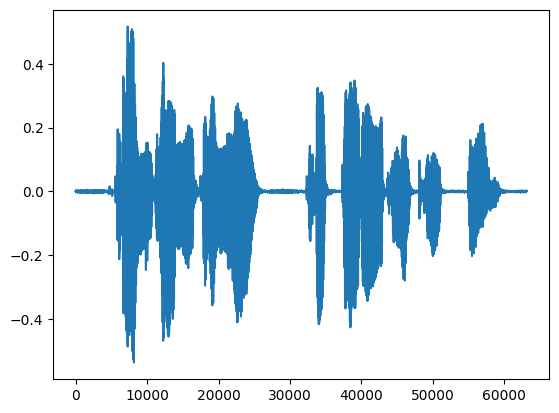

In [25]:
plt.plot(waveform[0])

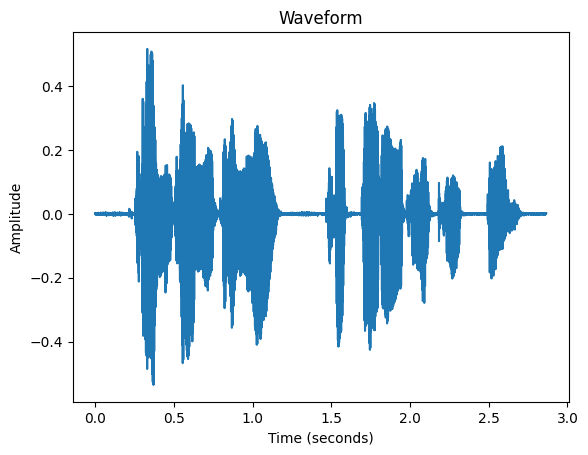

In [26]:
import numpy as np
time_axis = np.arange(0, len(waveform[0])) / sample_rate
plt.plot(time_axis, waveform[0])
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

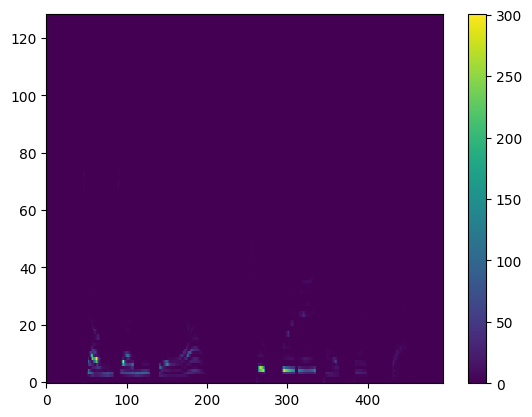

In [37]:
#Spectrogram

spec_converter = T.Spectrogram(
    n_fft=256)

spec = spec_converter(waveform)
plt.imshow(spec[0],aspect='auto',origin='lower',interpolation='none')
plt.colorbar()
plt.show()

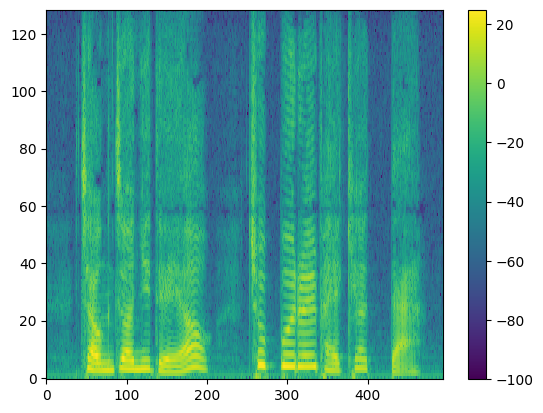

In [38]:
db_converter = T.AmplitudeToDB()
spec_db = db_converter(spec)
plt.imshow(spec_db[0],aspect='auto',origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [45]:
mel_converter = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=512,
    n_mels=80)
mel = mel_converter(waveform)
mel, mel.shape

(tensor([[[3.9793e-03, 6.9424e-03, 8.0753e-03,  ..., 8.8945e-03,
           9.2084e-03, 9.0215e-03],
          [9.8552e-03, 1.7194e-02, 1.9999e-02,  ..., 2.2028e-02,
           2.2805e-02, 2.2343e-02],
          [1.2540e-03, 2.3585e-02, 2.0833e-02,  ..., 2.3927e-02,
           2.3666e-02, 2.2638e-02],
          ...,
          [2.3920e-05, 2.9083e-05, 2.6790e-05,  ..., 2.3301e-05,
           8.8227e-06, 1.2787e-05],
          [1.6023e-05, 2.5755e-05, 2.0016e-05,  ..., 1.9481e-05,
           2.1566e-05, 1.7020e-05],
          [8.0704e-06, 1.4922e-05, 1.2369e-05,  ..., 1.0436e-05,
           1.3205e-05, 1.0474e-05]]]),
 torch.Size([1, 80, 247]))

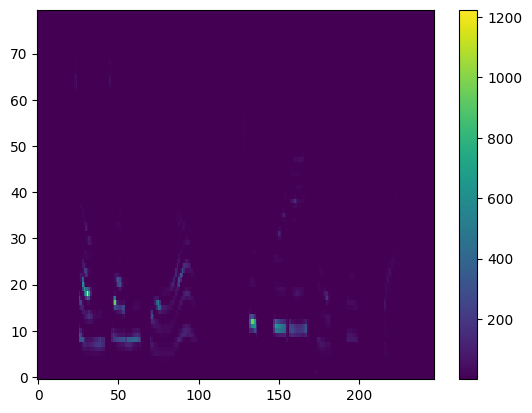

In [46]:
plt.imshow(mel[0],aspect='auto',origin='lower',interpolation='none')
plt.colorbar()
plt.show()

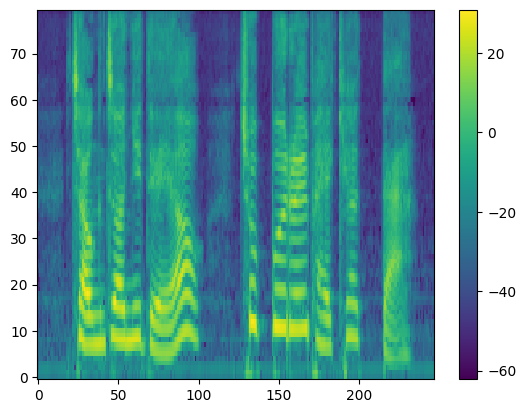

In [47]:
db_mel = db_converter(mel)
plt.imshow(db_mel[0],aspect='auto',origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [10]:
!ls

assets	    evaluate.py     LICENSE	  prepare_align.py  requirements.txt  train.py
audio	    fastspeech2.py  loss.py	  preprocessed	    synthesize.py     transformer
data	    generate.ipynb  modules.py	  preprocess.py     text	      utils.py
dataset.py  hparams.py	    optimizer.py  README.md	    TextGrid.zip      vocoder


## preprocessing

In [15]:
!python3 preprocess.py

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./preprocessed/kss/TextGrid/3_3006.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/4_3444.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/3_2861.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/3_0739.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/4_2180.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/2_0915.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/4_1518.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/2_0608.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/3_3223.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/4_3992.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/3_2196.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/4_4604.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/3_0364.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/4_1643.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/3_4284.TextGrid  
  inflating: ./preprocessed/kss/TextGrid/1_0849.TextGrid  
  inflating: ./prepr

In [ ]:
%python train.py

In [ ]:
url = 'https://drive.google.com/uc?id=1GxaLlTrEhq0aXFvd_X1f4b-ev7-FH8RB'
gdown.download(url,"./vocoder/pretrained_models/")

make log dir

In [ ]:
!mkdir -p log/kss

load tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir log/kss

Edit train.py

start train loop

In [ ]:
!python3 train.py